<a href="https://colab.research.google.com/drive/1ndRiC8gIlGlo0trpffxLkFRStxsaxMTC?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning SP 2022/2023

- Prof. Cesare Alippi
- Giorgia Adorni ([`giorgia.adorni@usi.ch`](mailto:giorgia.adorni@usi.ch))<br>
- Fatima Ezzeddine ([`fatima.ezzeddine@usi.ch`](mailto:fatima.ezzeddine@usi.ch))<br>
- Alessandro Manenti ([`alessandro.manenti@usi.ch`](mailto:alessandro.manenti@usi.ch))

---
# Lab 08: Forecasting


## Forecasting sunspots

![](https://upload.wikimedia.org/wikipedia/commons/4/47/Solar_Archipelago_-_Flickr_-_NASA_Goddard_Photo_and_Video.jpg)

As a case study we will cosider the problem of forecasting the number of **sunspots** using a dataset collected by the solar physics research department of the Royal Observatory of Belgium ([link](http://sidc.oma.be/)).

According to Wikipedia:

> Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

The datset is avaiable on Kaggle ([link](https://www.kaggle.com/robervalt/sunspots)) and frequently updated.

For semplicity (and reproducibility), we loaded a snapshot of the dataset in the repo of the course.

We start by installing the last version of statsmodels.

In [1]:
%pip install statsmodels -U

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/ascarrambad/ml-21-22/main/data/sunspots.csv"

df = pd.read_csv(url,
                 parse_dates=True,
                 index_col='Date',
                 usecols=['Date', 'Monthly Mean Total Sunspot Number'])
df = df.rename(columns={'Monthly Mean Total Sunspot Number':'sunspots'})

In [3]:
df.head()

,sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


Let's have a look at the data!

Text(0, 0.5, 'n. sunspots')

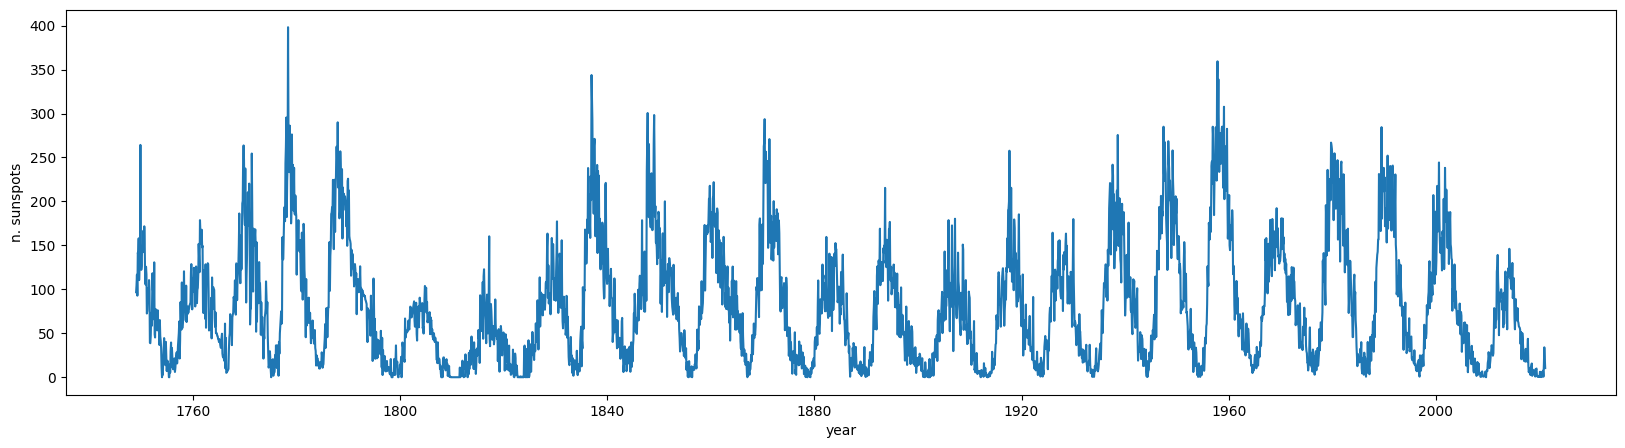

In [4]:
plt.figure(figsize=(20,5))
plt.plot(df.index, df['sunspots'])
plt.xlabel('year')
plt.ylabel('n. sunspots')

First of all let's split our data for model evaluation.

In [5]:
from sklearn.model_selection import train_test_split

# Prepare the data
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

# scale the data

mean = train_df.values.mean()
std = train_df.values.std()

scale = lambda x : (x - mean) / std
inv_scale = lambda x : x * std + mean

train_df = scale(train_df)
test_df = scale(test_df)

# THERE IS AN ERROR BEFORE, CAN YOU SPOT IT?

## A simple baseline

Simply use the value at the previous time-step to predict the next one.

BASELINE MSE: 9946.021257668712
BASELINE MAE: 77.41134969325152


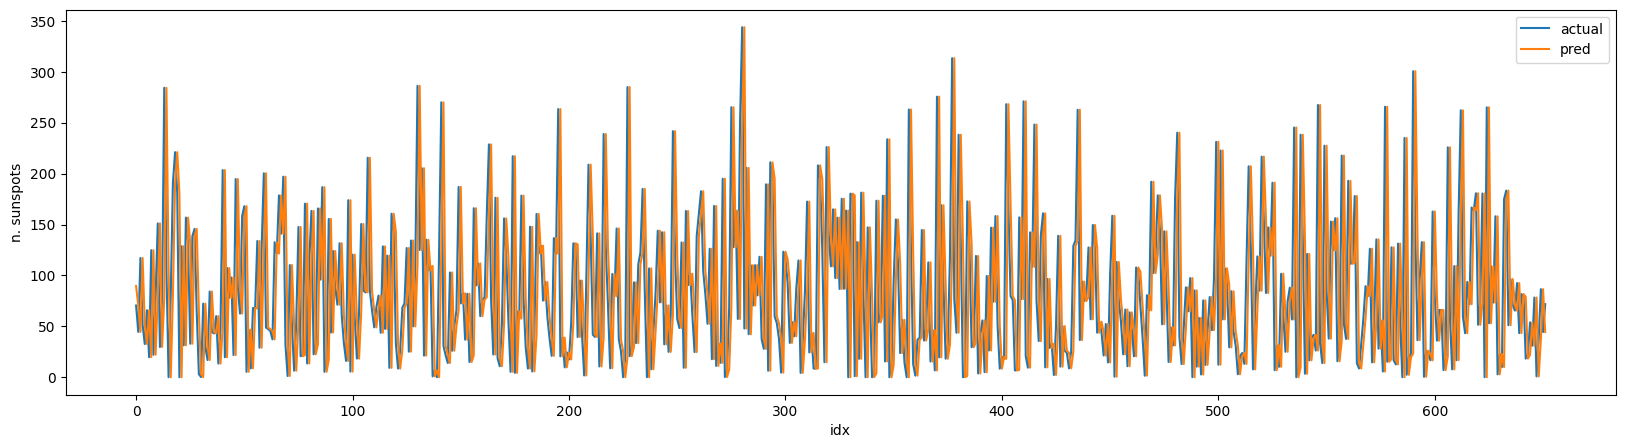

In [6]:
actuals = inv_scale(test_df.values.ravel())

mse = np.square(actuals[:-1] - actuals[1:]).mean()
print(f"BASELINE MSE: {mse}")
mae = np.abs(actuals[:-1] - actuals[1:]).mean()
print(f"BASELINE MAE: {mae}")


plt.figure(figsize=(20, 5))
plt.plot(actuals[1:], label='actual')
plt.plot(actuals[:-1], label='pred')
plt.xlabel('idx')
plt.ylabel('n. sunspots')
plt.legend()

### Linear models

Let's start with an AR model.

Documentation [here](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html)

In [7]:
from statsmodels.tsa.arima.model import ARIMA

#ARIMA(p,i,q)
model = ARIMA(train_df, order=(3, 0, 0), trend='n')

fit = model.fit()
print(fit.summary())

# appends test_df to avaiable data
fit = fit.append(test_df, refit=False)

actuals = test_df.values.ravel()
preds = fit.predict(start=len(train_df)).values.ravel()

mse = np.square(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"\n\nTEST MSE: {mse}")
mae = np.abs(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"TEST MAE: {mae}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:               sunspots   No. Observations:                 2612
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -3705.307
Date:                Fri, 17 Jan 2025   AIC                           7418.614
Time:                        17:41:52   BIC                           7442.085
Sample:                             0   HQIC                          7427.116
                               - 2612                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0061      0.019      0.325      0.745      -0.031       0.043
ar.L2          0.0005      0.019      0.024      0.981      -0.037       0.038
ar.L3          0.0264      0.019      1.386      0.1

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: Given `endog` does not have an index that extends the index of the model.

In [ ]:
preds = fit.predict(start=len(train_df), dynamic=False)

plt.figure(figsize=(20, 5))
plt.plot(inv_scale(test_df), label='actual')
plt.plot(inv_scale(preds), label='pred')
plt.xlabel('year')
plt.ylabel('n. sunspots')

plt.legend()
plt.show()

for `dynamic` parameter in `predict` method look [here](https://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.arima_model.ARIMA.predict.html#statsmodels.tsa.arima_model.ARIMA.predict)

In [ ]:
# one-step prediction
y_pred = fit.predict(start=len(train_df), dynamic=False) #dynamic

# recursie prediction
n_last = 300
y_new = fit.predict(start=len(train_df) + len(test_df) - n_last, dynamic=True)

plt.figure(figsize=(12, 5))
plt.plot(test_df, label="actual")
plt.plot(y_pred, label="pred")
plt.plot(y_new, label="new")
plt.xlabel('year')
plt.ylabel('n. sunspots')
plt.legend()

## Nonlinear Autoregressive models

### Let's divide data into windows

```
            historical data                   | future observations
--------------------------------------------------------------------
x(1) x(2) ... x(t-p) x(t-p+1) ... x(t-1) x(t) | x(t+1)  x(t+2) ...
                    \________________________/| \____/
                       time window            | value to
                                              | be predicted
```

In [ ]:
# Time windows
def get_time_windows(sequence, window_size):
    time = np.arange(sequence.shape[0])
    xseq = []
    yseq = []
    for t in time[:-window_size]:
        xseq.append(sequence[t:t+window_size])
        yseq.append(sequence[t+window_size])
    xseq = np.array(xseq)
    yseq = np.array(yseq)
    #train-test split
    return xseq, yseq.ravel()


In [ ]:
# Prepare the data
p = 24

x_train, y_train = get_time_windows(sequence=train_df.values.ravel(), window_size=p)
x_test, y_test = get_time_windows(sequence=test_df.values.ravel(), window_size=p)
print("training data", x_train.shape, y_train.shape)
print("test data", x_test.shape, y_test.shape)

We can use the usual syntax to build a neural network with keras and train it to predict the next value in the time-series.

We can formulate it as a regression problem.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape

# Build a model
def get_model(win_size):
    model = Sequential()
    model.add(Dense(64, activation="relu", input_shape=(win_size,)))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer="adam", loss="mse")
    return model

In [ ]:
# Prepare the data
p = 24

x_train, y_train = get_time_windows(sequence=train_df.values.ravel(), window_size=p)
x_test, y_test = get_time_windows(sequence=test_df.values.ravel(), window_size=p)

# Train the model
model = get_model(p)
history = model.fit(x_train, y_train, epochs=50)

preds = model.predict(x_test).ravel()

mse = np.square(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MSE: {mse}")
mae = np.abs(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MAE: {mae}")

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10, 8))

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='train_loss', c='C0')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

plot_history(history)


In [ ]:
# Predictions
y_pred = model.predict(x_test)

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="actual")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="pred")
plt.legend()

It looks like that the NAR model is not very good.

Let's see what happens with recursive predictions.

In [ ]:
# Predict on our prediction
def predict_rec(n, model, x_init):
    p = x_init.shape[0]

    y_new = np.zeros(p+n)
    y_new[:p] = x_init.copy()

    for j in range(n):
        y_tmp = model.predict(y_new[j:j+p][None, ...])
        y_new[j+p] = y_tmp[-1,0]
    return y_new[p:]

In [ ]:
# one-step prediction
y_pred = model.predict(x_test)

# one-step prediction
n_last = 300
y_new = predict_rec(n=n_last, model=model, x_init=x_test[-n_last-1])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="ground truth")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="predicted")
plt.plot(np.arange(y_test.shape[0]-n_last, y_test.shape[0]), y_new, label="new")
plt.legend()

## Recurrent neural networks

Finally let's try out a more advanced architecture: SimpleRNN networks. Documentation [here](https://keras.io/api/layers/recurrent_layers/simple_rnn/)

In [ ]:
from tensorflow.keras.layers import SimpleRNN

# Build a model
def get_model(win_size):
    model = Sequential()
    model.add(Reshape((-1, 1), input_shape=(None,))) # [batch, time, features]
    model.add(SimpleRNN(16))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer="adam", loss="mse")
    return model

Some weight initialization documentation: [Xavier](https://cs230.stanford.edu/section/4/#xavier-initialization), [Glorot](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [ ]:
# Prepare the data
p = 24

x_train, y_train = get_time_windows(sequence=train_df.values.ravel(), window_size=p)
x_test, y_test = get_time_windows(sequence=test_df.values.ravel(), window_size=p)

# Train the model
model = get_model(p)
model.fit(x_train, y_train, epochs=50)

preds = model.predict(x_test).ravel()

mse = np.square(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MSE: {mse}")

mae = np.abs(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MSE: {mae}")

In [ ]:
# Predictions
y_pred = model.predict(x_test)

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="actual")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="pred")
plt.legend()

In [ ]:
# Predict on our prediction
def predict_rec(n, model, x_init):
    p = x_init.shape[0]

    y_new = np.zeros(p+n)
    y_new[:p] = x_init.copy()

    for j in range(n):
        y_tmp = model.predict(y_new[:j+p][None, ...])  # the rnn can handle sequences of arbitrary lenght
        y_new[j+p] = y_tmp[-1,0]
    return y_new[p:]

In [ ]:
# one-step prediction
y_pred = model.predict(x_test)

# one-step prediction
n_last = 300
y_new = predict_rec(n=n_last, model=model, x_init=x_test[-n_last-1])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="ground truth")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="predicted")
plt.plot(np.arange(y_test.shape[0]-n_last, y_test.shape[0]), y_new, label="new")
plt.legend()

In [ ]:
# NOW TRY LSTM BY YOURSELF!

Many more things left to explore:

* take seasonality into account;
* add exogenous variables (e.g., date/time of the year/...);
* multi-step forecasting;
* try CNNs;
* ...

Give a look at [prophet](https://facebook.github.io/prophet/).